# Phase 4: Modeling — Exploratory Data Analysis

**Project**: PequeShop EDA — Exploratory Data Analysis for Commercial Decisions  
**Author**: Jose Marcel Lopez Pino  
**Date**: 2026-02-19  
**Framework**: CRISP-DM + Lean  
**Module**: 4 — Exploratory Data Analysis (Bootcamp SENCE/Alkemy)  

---

## Context

This notebook is Phase 4 (Modeling) of the PequeShop analytics project.  
Phases 1-3 (Business Understanding, Data Understanding, Data Preparation)  
were completed in **Project 2: PequeShop Data Preparation**  
([see repository](../../../project-2-pequeshop-analytics/)).

**Lean principle**: No re-work. We load clean, analysis-ready data from  
the previous project and focus entirely on exploratory analysis,  
statistical modeling, and insight generation.

## Business Questions (from Phase 1)

1. What customer segments drive the most revenue?
2. Does NPS score predict purchasing behavior?
3. Which variables best explain total transaction amount?
4. Are there significant differences across regions, channels, or platforms?

## Module 4 Lessons Covered

| Lesson | Topic | Section |
|--------|-------|---------|
| L1 | Exploratory Data Analysis (EDA vs IDA) | 4.1 |
| L2 | Descriptive Statistics | 4.2 |
| L3 | Correlation | 4.3 |
| L4 | Linear Regression | 4.4 |

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

# Project imports
import sys
sys.path.append('..')
from config.config import DATA_RAW, FIGURES

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150

%matplotlib inline

print('Libraries loaded successfully.')

Libraries loaded successfully.


## 4.0 Load Analysis-Ready Data

Data was cleaned and prepared in Project 2 (Module 3).  
We load the processed datasets directly — no re-work needed.

In [2]:
# =============================================================================
# LOAD PROCESSED DATA FROM PROJECT 2
# =============================================================================

df_customers = pd.read_csv(DATA_RAW / 'customers_final.csv')
df_transactions = pd.read_csv(DATA_RAW / 'transactions_final.csv')

# Parse dates
date_cols_customers = ['registration_date', 'first_purchase', 'last_purchase']
for col in date_cols_customers:
    df_customers[col] = pd.to_datetime(df_customers[col], errors='coerce')

df_transactions['transaction_date'] = pd.to_datetime(
    df_transactions['transaction_date'], errors='coerce'
)

print(f'Customers: {df_customers.shape[0]} rows, {df_customers.shape[1]} columns')
print(f'Transactions: {df_transactions.shape[0]} rows, {df_transactions.shape[1]} columns')
print(f'Total Revenue: ${df_transactions["total_amount"].sum():,.0f} CLP')

Customers: 500 rows, 16 columns
Transactions: 1192 rows, 19 columns
Total Revenue: $37,546,463 CLP


---

## 4.1 Exploratory Data Analysis (Lesson 1)

### EDA vs IDA

| Aspect | IDA (done in Project 2) | EDA (this notebook) |
|--------|------------------------|---------------------|
| **Goal** | Assess data quality | Discover patterns and relationships |
| **Focus** | Nulls, types, outliers | Distributions, correlations, trends |
| **Output** | Clean dataset | Insights and hypotheses |

### 4.1.1 Variable Classification

In [3]:
# =============================================================================
# VARIABLE CLASSIFICATION — CUSTOMERS
# =============================================================================

print('CUSTOMERS DATASET')
print('=' * 70)

# Separate by type
numeric_cols = df_customers.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_customers.select_dtypes(
    include=['object', 'string', 'bool', 'category']
).columns.tolist()
date_cols = df_customers.select_dtypes(include=['datetime64']).columns.tolist()

print(f'\nNumeric ({len(numeric_cols)}): {numeric_cols}')
print(f'\nCategorical ({len(categorical_cols)}): {categorical_cols}')
print(f'\nDatetime ({len(date_cols)}): {date_cols}')

CUSTOMERS DATASET

Numeric (7): ['customer_id', 'nps_score', 'total_transactions', 'total_revenue', 'avg_ticket', 'days_since_last_purchase', 'tenure_days']

Categorical (6): ['region', 'acquisition_channel', 'nps_category', 'retargeting_segment', 'is_high_value', 'priority_winback']

Datetime (3): ['registration_date', 'first_purchase', 'last_purchase']


In [4]:
# =============================================================================
# VARIABLE CLASSIFICATION — TRANSACTIONS
# =============================================================================

print('TRANSACTIONS DATASET')
print('=' * 70)

numeric_tx = df_transactions.select_dtypes(include=[np.number]).columns.tolist()
categorical_tx = df_transactions.select_dtypes(
    include=['object', 'string', 'bool', 'category']
).columns.tolist()
date_tx = df_transactions.select_dtypes(include=['datetime64']).columns.tolist()

print(f'\nNumeric ({len(numeric_tx)}): {numeric_tx}')
print(f'\nCategorical ({len(categorical_tx)}): {categorical_tx}')
print(f'\nDatetime ({len(date_tx)}): {date_tx}')

TRANSACTIONS DATASET

Numeric (11): ['customer_id', 'quantity', 'unit_price', 'subtotal', 'shipping_cost', 'platform_fee', 'total_amount', 'year', 'month', 'quarter', 'day_of_week']

Categorical (7): ['transaction_id', 'platform', 'product', 'is_bulk_order', 'is_weekend', 'season', 'year_quarter']

Datetime (1): ['transaction_date']


### 4.1.2 Data Overview

In [5]:
# =============================================================================
# QUICK DATA OVERVIEW
# =============================================================================

print('CUSTOMERS — Missing Values')
print('-' * 40)
missing = df_customers.isnull().sum()
missing_pct = (missing / len(df_customers) * 100).round(1)
missing_summary = pd.DataFrame({
    'missing': missing,
    'pct': missing_pct
}).query('missing > 0')
print(missing_summary)
print(f'\nNote: 108 customers registered but never purchased (expected).')
print(f'265 customers did not respond to NPS survey.')

CUSTOMERS — Missing Values
----------------------------------------
                          missing   pct
nps_score                     265 53.00
total_transactions            108 21.60
total_revenue                 108 21.60
avg_ticket                    108 21.60
first_purchase                108 21.60
last_purchase                 108 21.60
days_since_last_purchase      108 21.60
tenure_days                   108 21.60
retargeting_segment           108 21.60

Note: 108 customers registered but never purchased (expected).
265 customers did not respond to NPS survey.


---

## 4.2 Descriptive Statistics (Lesson 2)

### 4.2.1 Central Tendency and Dispersion

In [6]:
# =============================================================================
# DESCRIPTIVE STATISTICS — TRANSACTIONS
# =============================================================================

key_metrics = ['unit_price', 'quantity', 'total_amount', 'shipping_cost']

desc_stats = df_transactions[key_metrics].agg([
    'count', 'mean', 'median', 'std', 'var', 'min', 'max',
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75),
    lambda x: stats.mode(x, keepdims=True).mode[0]
])
desc_stats.index = [
    'count', 'mean', 'median', 'std', 'variance',
    'min', 'max', 'Q1 (25%)', 'Q3 (75%)', 'mode'
]

print('TRANSACTION METRICS — Descriptive Statistics')
print('=' * 70)
print(desc_stats.T)

TRANSACTION METRICS — Descriptive Statistics
                 count      mean    median       std       variance      min  \
unit_price    1,192.00 15,141.59 13,712.50  7,626.68  58,166,288.08 3,010.00   
quantity      1,192.00      1.95      2.00      1.72           2.96     1.00   
total_amount  1,192.00 31,498.71 26,333.50 21,733.21 472,332,217.93 4,490.00   
shipping_cost 1,192.00  2,746.64  3,500.00  2,063.94   4,259,854.39     0.00   

                     max  Q1 (25%)  Q3 (75%)      mode  
unit_price     34,809.00 10,600.00 19,990.00 12,990.00  
quantity           50.00      1.00      3.00      1.00  
total_amount  249,500.00 16,564.75 39,525.00 16,490.00  
shipping_cost   5,500.00      0.00  3,500.00  3,500.00  


In [7]:
# =============================================================================
# DESCRIPTIVE STATISTICS — CUSTOMERS
# =============================================================================

customer_metrics = [
    'total_transactions', 'total_revenue', 'avg_ticket',
    'days_since_last_purchase', 'tenure_days'
]

# Filter only customers with transactions
active_customers = df_customers.dropna(subset=['total_transactions'])

desc_customers = active_customers[customer_metrics].agg([
    'count', 'mean', 'median', 'std', 'var', 'min', 'max',
    lambda x: x.quantile(0.25),
    lambda x: x.quantile(0.75)
])
desc_customers.index = [
    'count', 'mean', 'median', 'std', 'variance',
    'min', 'max', 'Q1 (25%)', 'Q3 (75%)'
]

print('CUSTOMER METRICS — Descriptive Statistics (active customers only)')
print('=' * 70)
print(desc_customers.T)

CUSTOMER METRICS — Descriptive Statistics (active customers only)
                          count      mean    median       std  \
total_transactions       392.00      3.04      2.00      2.36   
total_revenue            392.00 95,781.79 66,786.00 86,048.48   
avg_ticket               392.00 30,860.45 28,004.31 14,873.32   
days_since_last_purchase 392.00    250.13    201.00    191.62   
tenure_days              392.00    263.52    241.00    245.27   

                                 variance      min        max  Q1 (25%)  \
total_transactions                   5.58     1.00      13.00      1.00   
total_revenue            7,404,340,671.48 6,990.00 402,964.00 32,906.75   
avg_ticket                 221,215,578.41 6,990.00 145,744.00 21,043.80   
days_since_last_purchase        36,718.54     0.00     760.00     91.00   
tenure_days                     60,158.82     0.00     724.00      0.00   

                           Q3 (75%)  
total_transactions             4.00  
total_revenue   

### 4.2.2 Distributions — Histograms

**Business insight**: Understanding the shape of distributions helps  
identify whether most customers behave similarly (normal) or if  
a few customers dominate (skewed — Pareto effect).

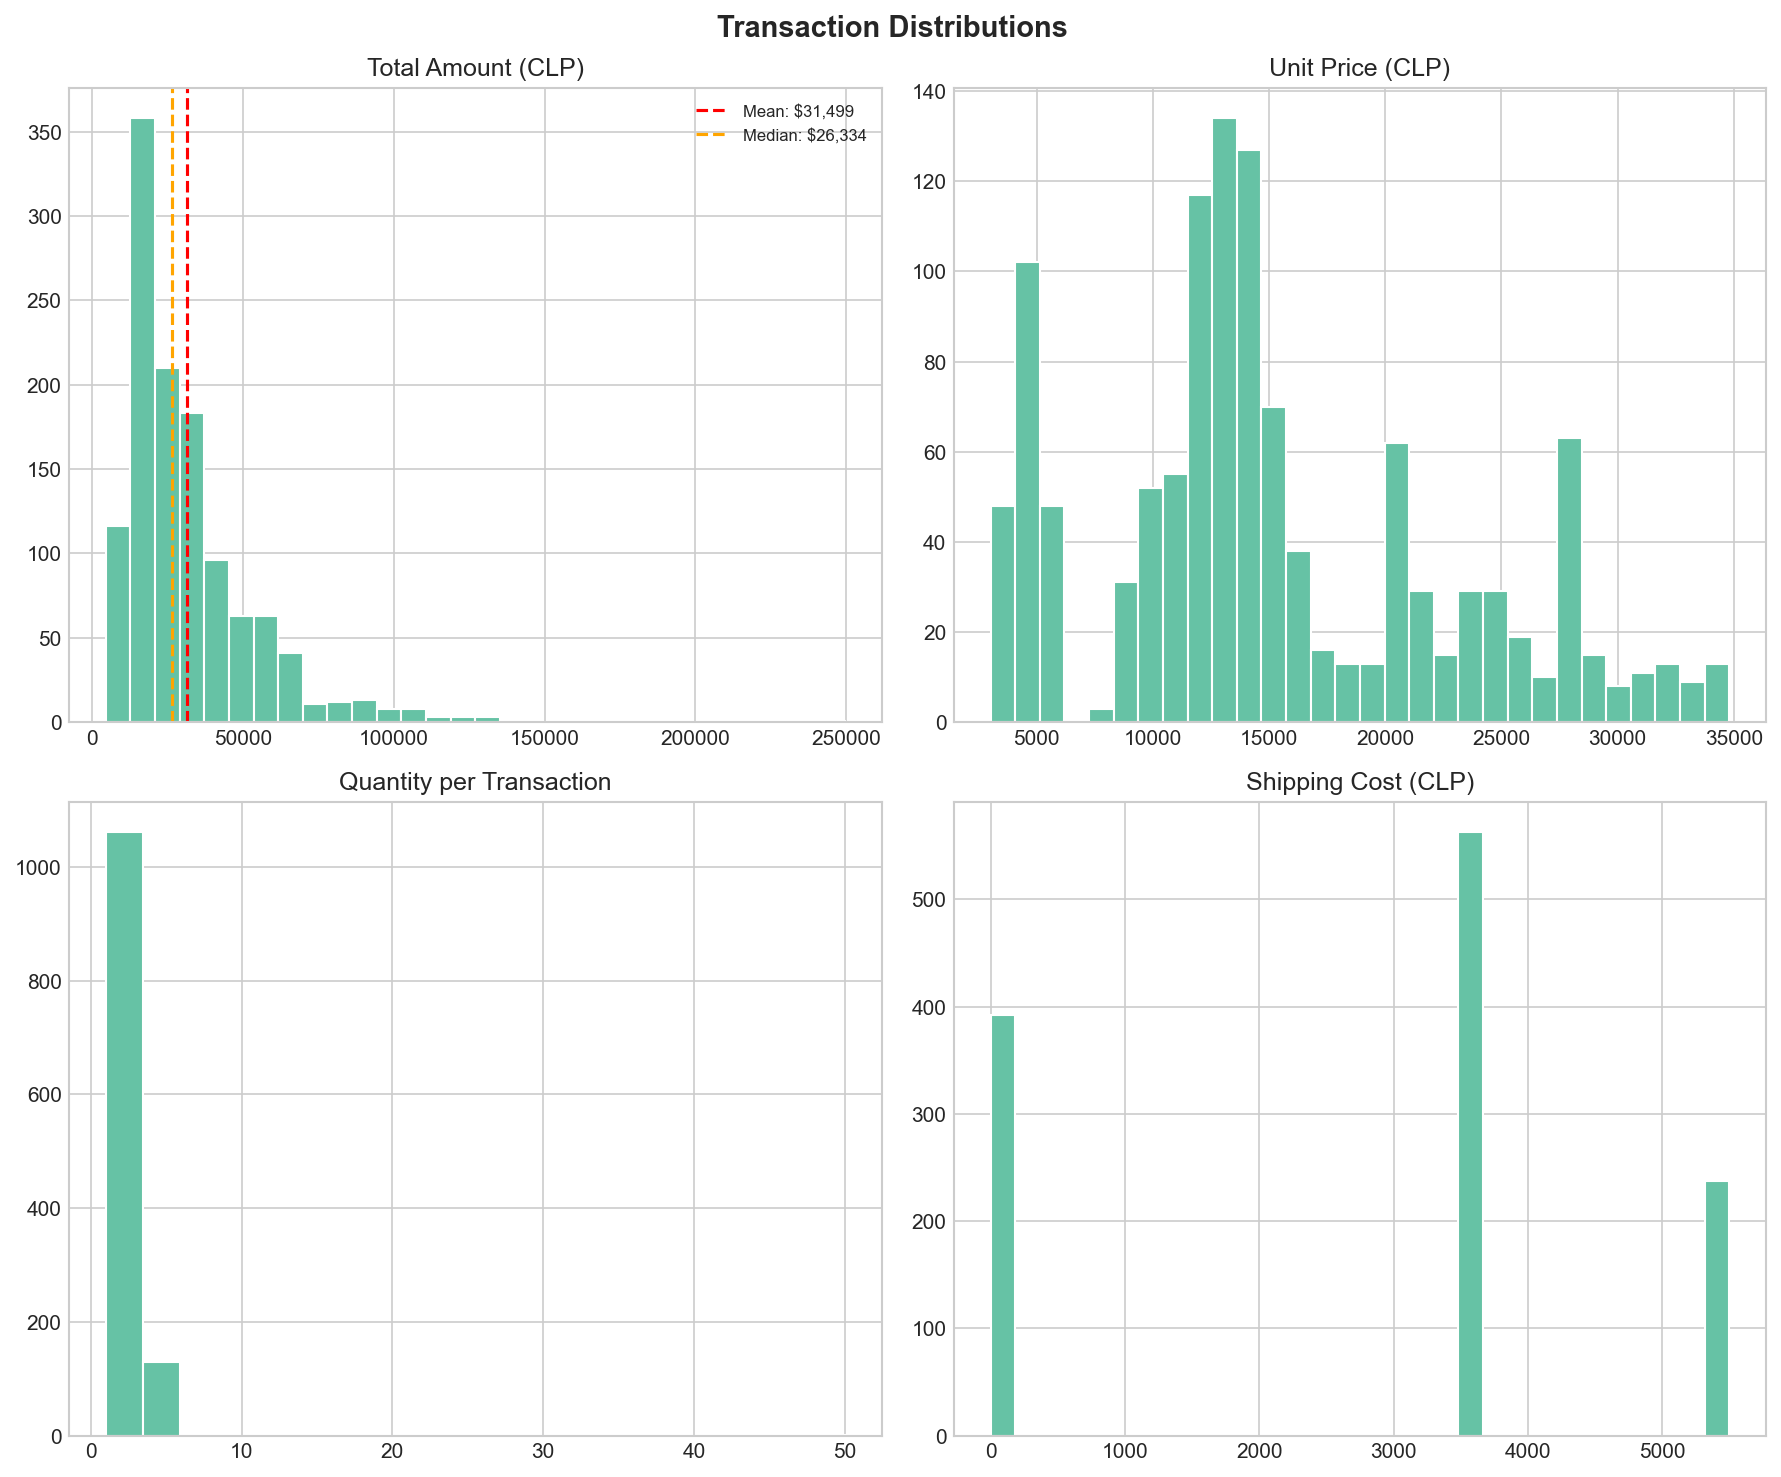

Figure saved: reports/figures/histograms_transactions.png


In [8]:
# =============================================================================
# HISTOGRAMS — TRANSACTION AMOUNTS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Transaction Distributions', fontsize=14, fontweight='bold')

# Total amount
axes[0, 0].hist(df_transactions['total_amount'], bins=30, edgecolor='white')
axes[0, 0].axvline(df_transactions['total_amount'].mean(), color='red',
                    linestyle='--', label=f"Mean: ${df_transactions['total_amount'].mean():,.0f}")
axes[0, 0].axvline(df_transactions['total_amount'].median(), color='orange',
                    linestyle='--', label=f"Median: ${df_transactions['total_amount'].median():,.0f}")
axes[0, 0].set_title('Total Amount (CLP)')
axes[0, 0].legend(fontsize=8)

# Unit price
axes[0, 1].hist(df_transactions['unit_price'], bins=30, edgecolor='white')
axes[0, 1].set_title('Unit Price (CLP)')

# Quantity
axes[1, 0].hist(df_transactions['quantity'], bins=20, edgecolor='white')
axes[1, 0].set_title('Quantity per Transaction')

# Shipping cost
axes[1, 1].hist(df_transactions['shipping_cost'], bins=30, edgecolor='white')
axes[1, 1].set_title('Shipping Cost (CLP)')

plt.tight_layout()
fig.savefig(FIGURES / 'histograms_transactions.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/histograms_transactions.png')

### 4.2.3 Boxplots — Outlier Detection

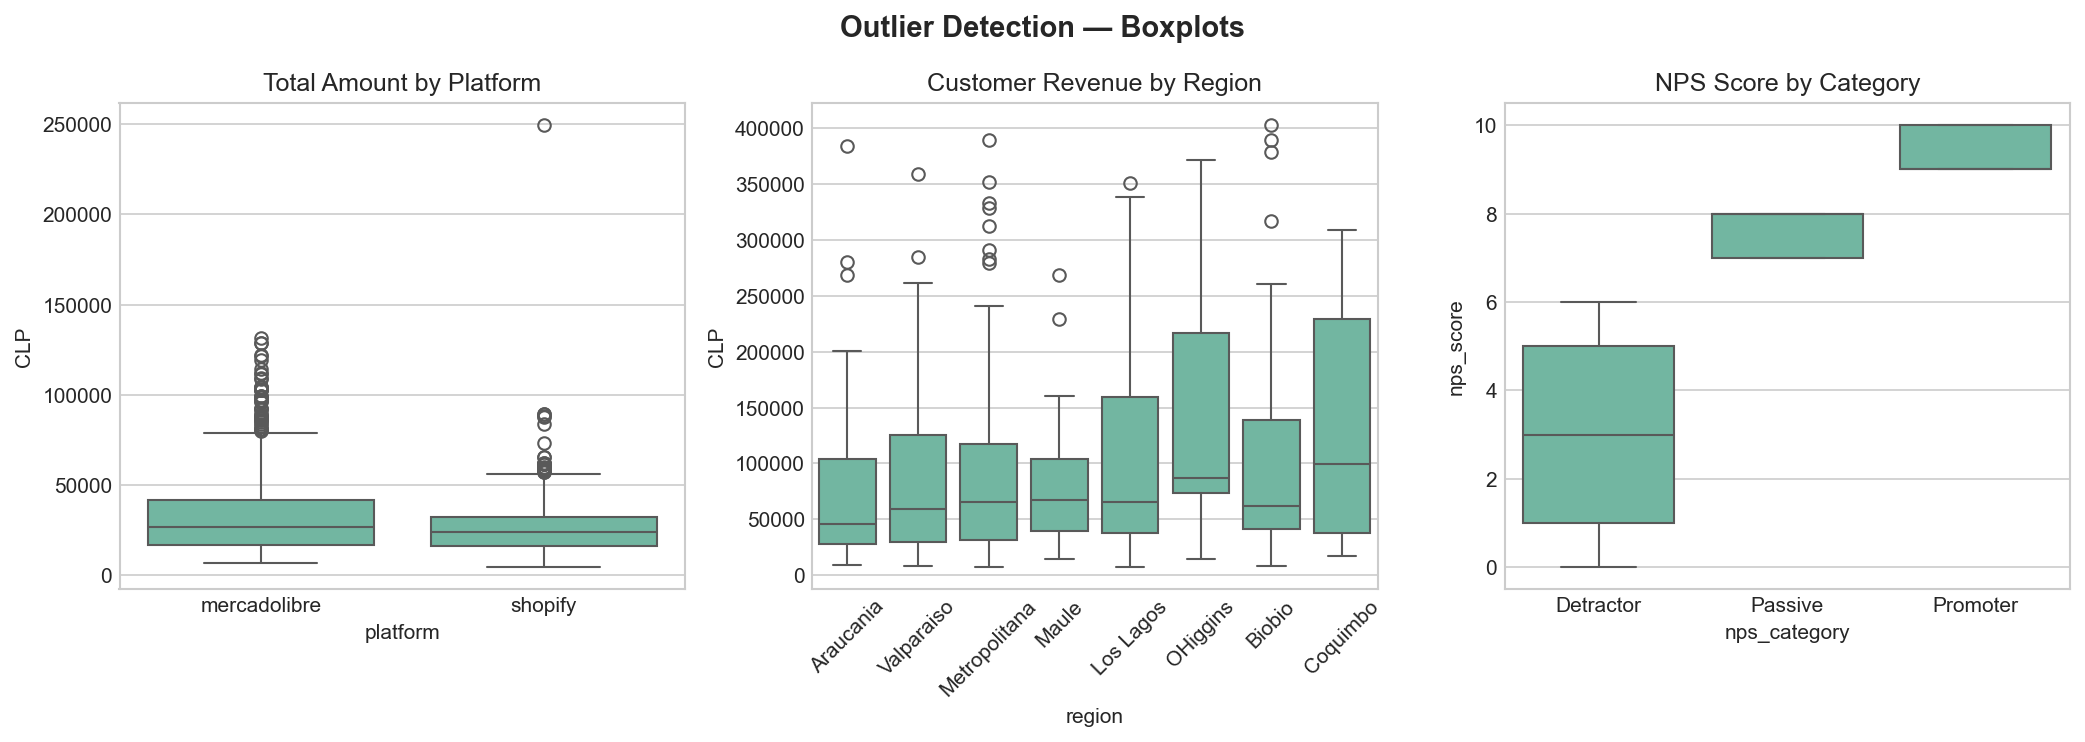

Figure saved: reports/figures/boxplots_outliers.png


In [9]:
# =============================================================================
# BOXPLOTS — OUTLIER DETECTION
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Outlier Detection — Boxplots', fontsize=14, fontweight='bold')

# Total amount by platform
sns.boxplot(data=df_transactions, x='platform', y='total_amount', ax=axes[0])
axes[0].set_title('Total Amount by Platform')
axes[0].set_ylabel('CLP')

# Revenue by region (customers)
sns.boxplot(data=active_customers, x='region', y='total_revenue', ax=axes[1])
axes[1].set_title('Customer Revenue by Region')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel('CLP')

# NPS score distribution
nps_respondents = df_customers.dropna(subset=['nps_score'])
sns.boxplot(data=nps_respondents, x='nps_category', y='nps_score', ax=axes[2],
            order=['Detractor', 'Passive', 'Promoter'])
axes[2].set_title('NPS Score by Category')

plt.tight_layout()
fig.savefig(FIGURES / 'boxplots_outliers.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/boxplots_outliers.png')

In [10]:
# =============================================================================
# OUTLIER QUANTIFICATION — IQR METHOD
# =============================================================================

def detect_outliers_iqr(series, name=''):
    """Detect outliers using the IQR method.

    Args:
        series: Pandas Series with numeric data.
        name: Variable name for display.

    Returns:
        Dictionary with outlier statistics.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = series[(series < lower) | (series > upper)]

    return {
        'variable': name,
        'Q1': q1,
        'Q3': q3,
        'IQR': iqr,
        'lower_bound': lower,
        'upper_bound': upper,
        'n_outliers': len(outliers),
        'pct_outliers': len(outliers) / len(series) * 100
    }


outlier_vars = ['total_amount', 'unit_price', 'quantity', 'shipping_cost']
outlier_results = [
    detect_outliers_iqr(df_transactions[col], col) for col in outlier_vars
]

df_outliers = pd.DataFrame(outlier_results).set_index('variable')
print('OUTLIER DETECTION — IQR Method')
print('=' * 70)
print(df_outliers)

OUTLIER DETECTION — IQR Method
                     Q1        Q3       IQR  lower_bound  upper_bound  \
variable                                                                
total_amount  16,564.75 39,525.00 22,960.25   -17,875.62    73,965.38   
unit_price    10,600.00 19,990.00  9,390.00    -3,485.00    34,075.00   
quantity           1.00      3.00      2.00        -2.00         6.00   
shipping_cost      0.00  3,500.00  3,500.00    -5,250.00     8,750.00   

               n_outliers  pct_outliers  
variable                                 
total_amount           57          4.78  
unit_price              9          0.76  
quantity                1          0.08  
shipping_cost           0          0.00  


### 4.2.4 Interpretation

**Key findings from descriptive statistics:**

- **Total amount** distribution is right-skewed (mean > median), indicating  
  a Pareto pattern: a few large transactions inflate the average.  
  *Business implication*: Use median for typical customer behavior, mean for  
  revenue planning.

- **108 customers** (21.6%) registered but never purchased — a clear  
  conversion opportunity.

- **265 customers** (53%) did not respond to NPS — potential non-response bias  
  must be considered when interpreting NPS metrics.

---

## 4.3 Correlation Analysis (Lesson 3)

### 4.3.1 Correlation Matrix — Transactions

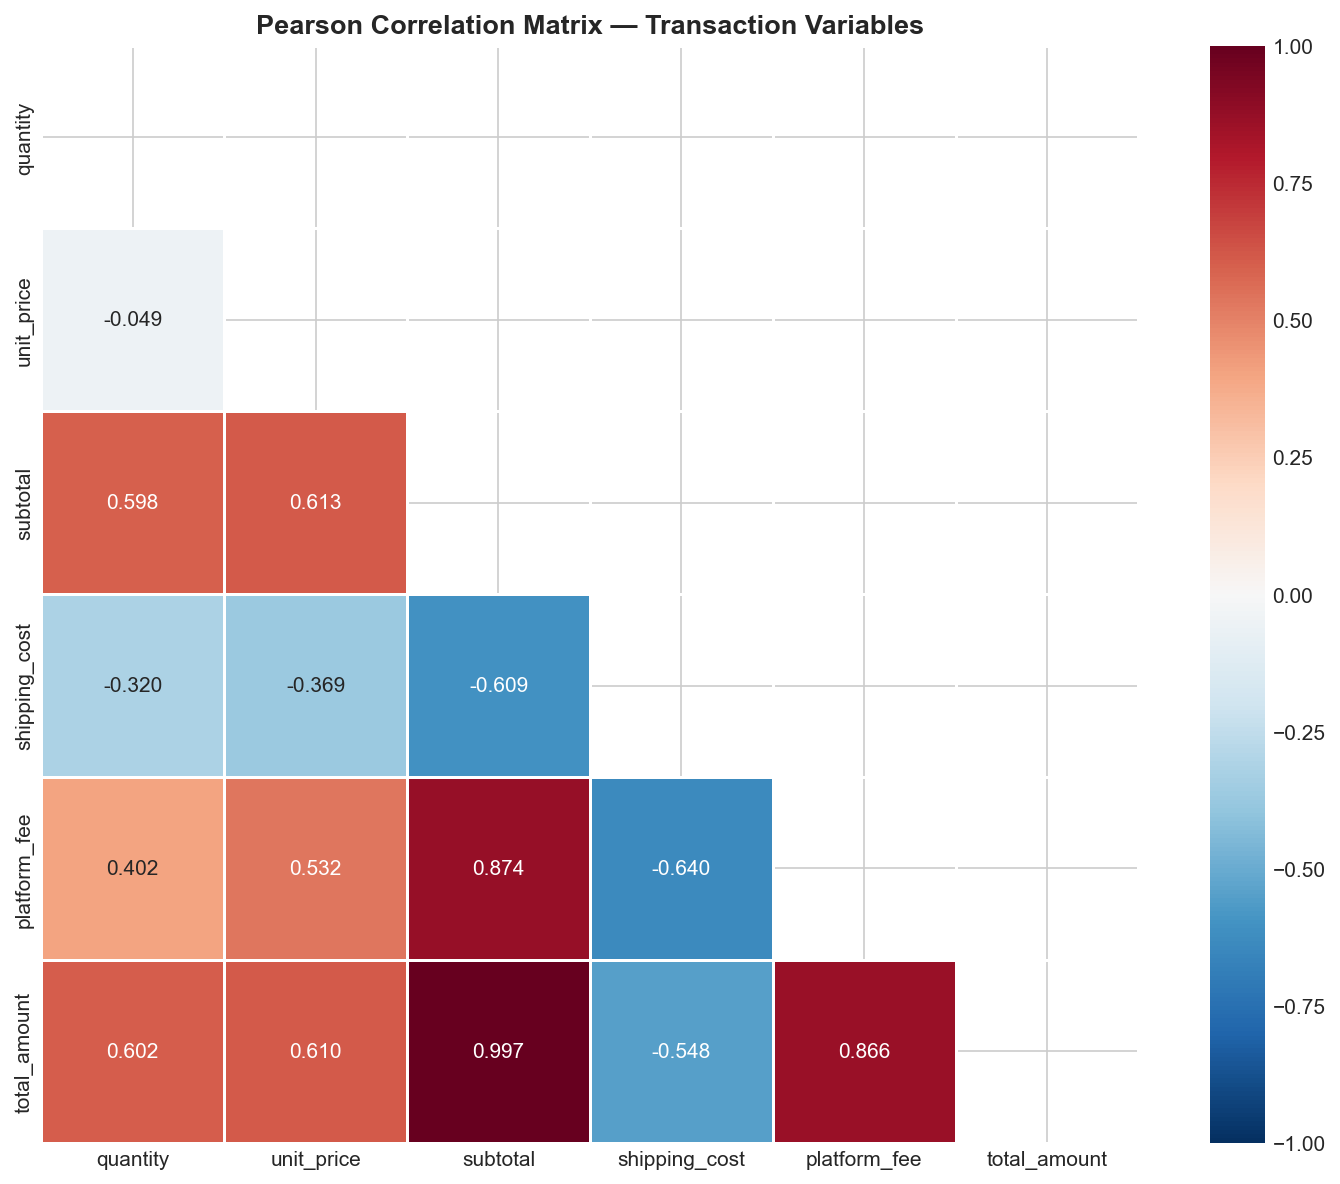

Figure saved: reports/figures/correlation_matrix_transactions.png


In [11]:
# =============================================================================
# CORRELATION MATRIX — TRANSACTION NUMERICS
# =============================================================================

corr_cols = [
    'quantity', 'unit_price', 'subtotal',
    'shipping_cost', 'platform_fee', 'total_amount'
]

corr_matrix = df_transactions[corr_cols].corr(method='pearson')

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    ax=ax
)
ax.set_title('Pearson Correlation Matrix — Transaction Variables',
             fontsize=13, fontweight='bold')

plt.tight_layout()
fig.savefig(FIGURES / 'correlation_matrix_transactions.png',
            bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/correlation_matrix_transactions.png')

### 4.3.2 Correlation Matrix — Customer Metrics

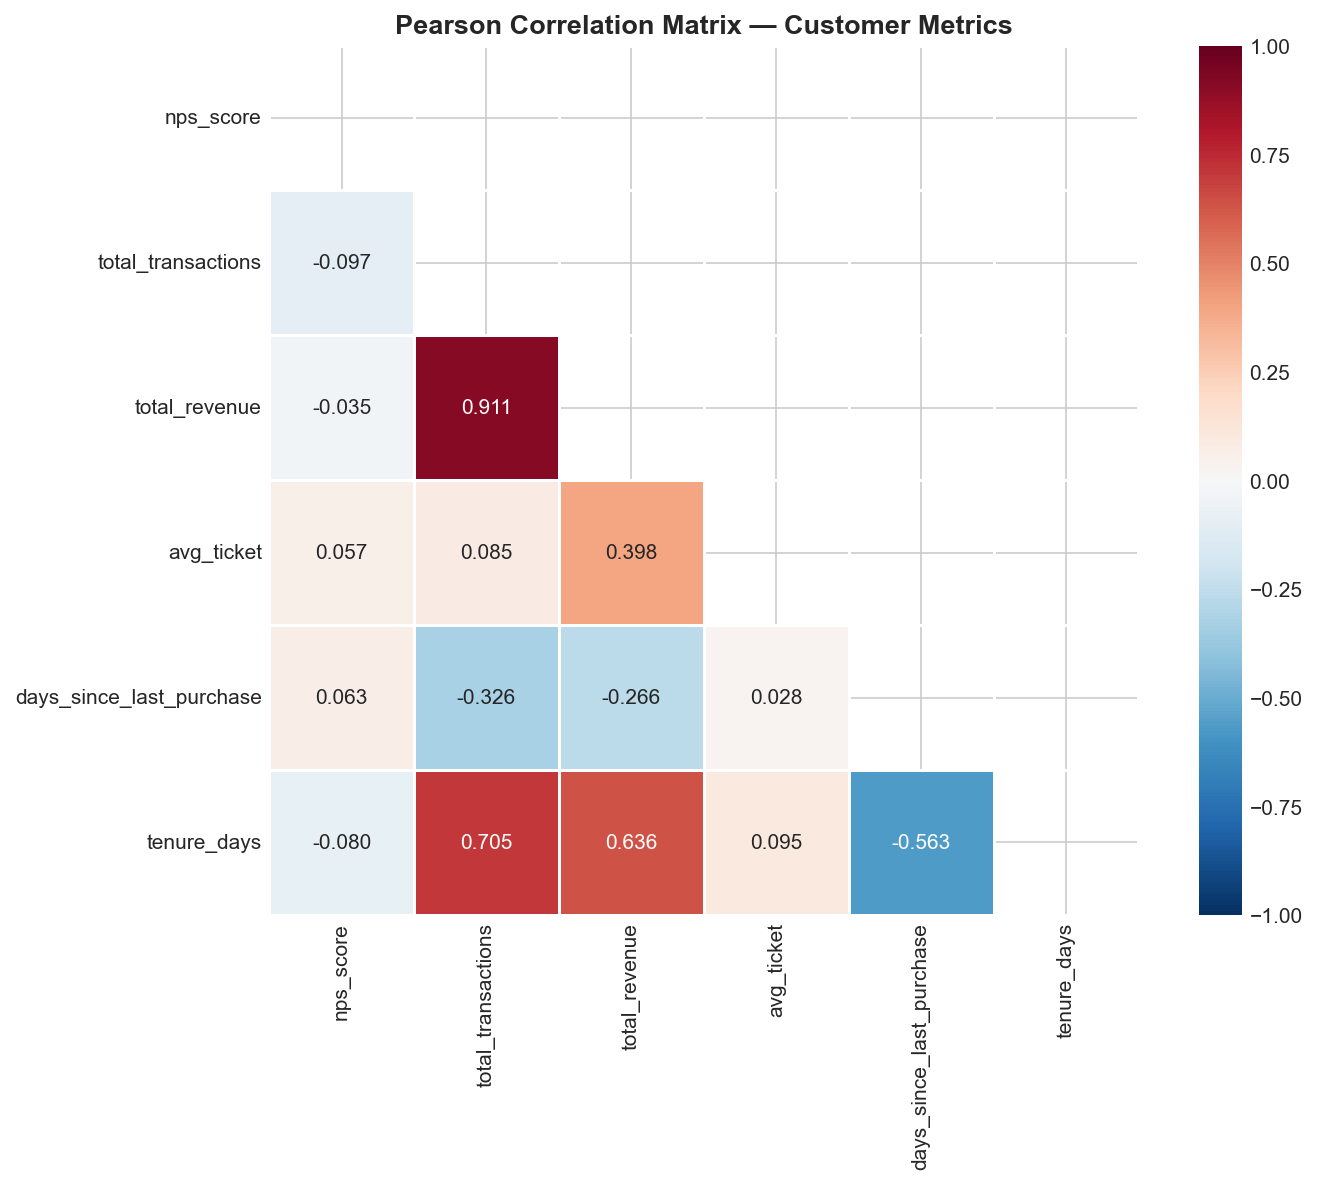

Figure saved: reports/figures/correlation_matrix_customers.png


In [12]:
# =============================================================================
# CORRELATION MATRIX — CUSTOMER METRICS
# =============================================================================

customer_corr_cols = [
    'nps_score', 'total_transactions', 'total_revenue',
    'avg_ticket', 'days_since_last_purchase', 'tenure_days'
]

# Use only customers with both NPS and transactions
df_complete = active_customers.dropna(subset=['nps_score'])
corr_customers = df_complete[customer_corr_cols].corr(method='pearson')

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_customers, dtype=bool))
sns.heatmap(
    corr_customers,
    mask=mask,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    ax=ax
)
ax.set_title('Pearson Correlation Matrix — Customer Metrics',
             fontsize=13, fontweight='bold')

plt.tight_layout()
fig.savefig(FIGURES / 'correlation_matrix_customers.png',
            bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/correlation_matrix_customers.png')

### 4.3.3 Scatterplots — Key Relationships

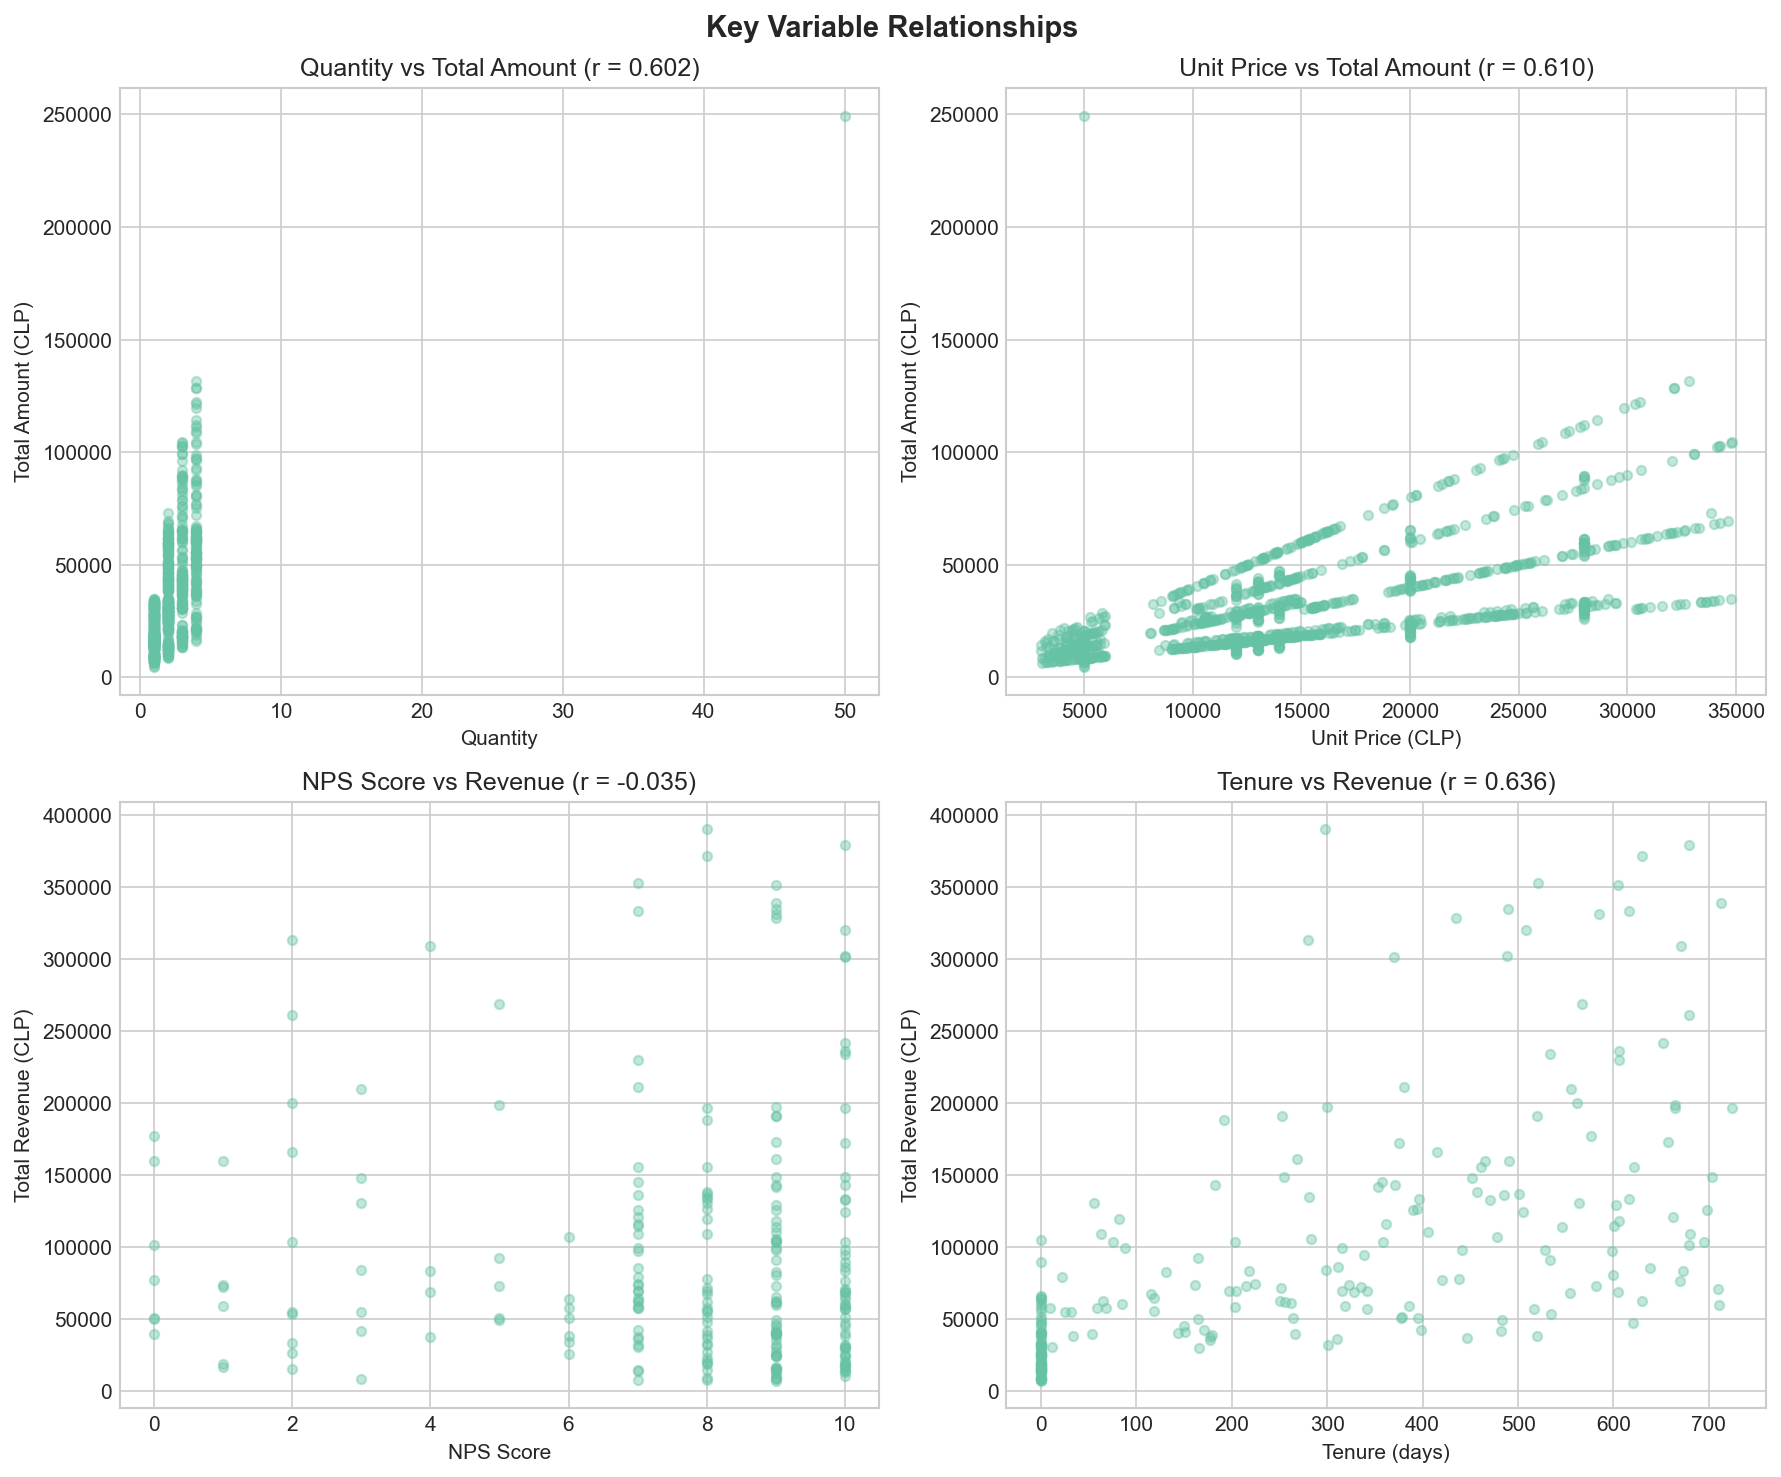

Figure saved: reports/figures/scatterplots_relationships.png


In [13]:
# =============================================================================
# SCATTERPLOTS — KEY RELATIONSHIPS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Key Variable Relationships', fontsize=14, fontweight='bold')

# 1. Quantity vs Total Amount
axes[0, 0].scatter(df_transactions['quantity'],
                   df_transactions['total_amount'], alpha=0.4, s=20)
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Total Amount (CLP)')
r_qty = df_transactions[['quantity', 'total_amount']].corr().iloc[0, 1]
axes[0, 0].set_title(f'Quantity vs Total Amount (r = {r_qty:.3f})')

# 2. Unit Price vs Total Amount
axes[0, 1].scatter(df_transactions['unit_price'],
                   df_transactions['total_amount'], alpha=0.4, s=20)
axes[0, 1].set_xlabel('Unit Price (CLP)')
axes[0, 1].set_ylabel('Total Amount (CLP)')
r_price = df_transactions[['unit_price', 'total_amount']].corr().iloc[0, 1]
axes[0, 1].set_title(f'Unit Price vs Total Amount (r = {r_price:.3f})')

# 3. NPS vs Total Revenue (customers)
axes[1, 0].scatter(df_complete['nps_score'],
                   df_complete['total_revenue'], alpha=0.4, s=20)
axes[1, 0].set_xlabel('NPS Score')
axes[1, 0].set_ylabel('Total Revenue (CLP)')
r_nps = df_complete[['nps_score', 'total_revenue']].corr().iloc[0, 1]
axes[1, 0].set_title(f'NPS Score vs Revenue (r = {r_nps:.3f})')

# 4. Tenure vs Total Revenue
axes[1, 1].scatter(df_complete['tenure_days'],
                   df_complete['total_revenue'], alpha=0.4, s=20)
axes[1, 1].set_xlabel('Tenure (days)')
axes[1, 1].set_ylabel('Total Revenue (CLP)')
r_tenure = df_complete[['tenure_days', 'total_revenue']].corr().iloc[0, 1]
axes[1, 1].set_title(f'Tenure vs Revenue (r = {r_tenure:.3f})')

plt.tight_layout()
fig.savefig(FIGURES / 'scatterplots_relationships.png',
            bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/scatterplots_relationships.png')

### 4.3.4 Spurious Correlations

**Important**: Correlation does NOT imply causation.

Some correlations in this dataset are **structural** (not informative):  
- `subtotal` vs `total_amount` (r ≈ 0.997): subtotal is a component  
  of total_amount → this is a **mathematical relationship**, not a pattern.  
- `platform_fee` vs `total_amount` (r ≈ 0.866): fees are calculated  
  as a percentage of amount → also structural.

**Meaningful correlations** to investigate:  
- `quantity` vs `total_amount`: genuine purchasing behavior.  
- `unit_price` vs `total_amount`: product mix effect.  
- `nps_score` vs `total_revenue`: satisfaction → loyalty hypothesis.  
- `shipping_cost` vs `total_amount` (negative): higher-value items  
  may qualify for free shipping promotions.

---

## 4.4 Linear Regression (Lesson 4)

### 4.4.1 Simple Linear Regression

**Hypothesis**: Transaction total amount is explained by quantity purchased.  
**Business question**: How much does each additional unit increase revenue?

In [14]:
# =============================================================================
# SIMPLE LINEAR REGRESSION: quantity → total_amount
# =============================================================================

# Prepare data
X_simple = df_transactions['quantity']
X_simple = sm.add_constant(X_simple)  # Add intercept
y = df_transactions['total_amount']

# Fit model
model_simple = sm.OLS(y, X_simple).fit()

print('SIMPLE LINEAR REGRESSION: quantity → total_amount')
print('=' * 70)
print(model_simple.summary())

SIMPLE LINEAR REGRESSION: quantity → total_amount
                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     675.1
Date:                Thu, 19 Feb 2026   Prob (F-statistic):          2.91e-118
Time:                        16:39:44   Log-Likelihood:                -13327.
No. Observations:                1192   AIC:                         2.666e+04
Df Residuals:                    1190   BIC:                         2.667e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

In [15]:
# =============================================================================
# INTERPRETATION — SIMPLE MODEL
# =============================================================================

print('MODEL INTERPRETATION')
print('=' * 70)
print(f'Intercept (β₀): ${model_simple.params["const"]:,.0f} CLP')
print(f'  → Base transaction amount when quantity = 0')
print(f'\nSlope (β₁): ${model_simple.params["quantity"]:,.0f} CLP per unit')
print(f'  → Each additional unit adds ~${model_simple.params["quantity"]:,.0f} CLP to the transaction')
print(f'\nR² = {model_simple.rsquared:.4f}')
print(f'  → Quantity explains {model_simple.rsquared * 100:.1f}% of the variance in total amount')
print(f'\np-value (quantity): {model_simple.pvalues["quantity"]:.2e}')
print(f'  → Statistically significant (p < 0.05)' if model_simple.pvalues['quantity'] < 0.05 else '  → NOT statistically significant')

MODEL INTERPRETATION
Intercept (β₀): $16,651 CLP
  → Base transaction amount when quantity = 0

Slope (β₁): $7,606 CLP per unit
  → Each additional unit adds ~$7,606 CLP to the transaction

R² = 0.3620
  → Quantity explains 36.2% of the variance in total amount

p-value (quantity): 2.91e-118
  → Statistically significant (p < 0.05)


### 4.4.2 Multiple Linear Regression

**Hypothesis**: Total amount is better explained by combining  
quantity AND unit price.  
**Business question**: What drives transaction value — buying more  
items or buying premium products?

In [16]:
# =============================================================================
# MULTIPLE LINEAR REGRESSION: quantity + unit_price → total_amount
# =============================================================================

X_multi = df_transactions[['quantity', 'unit_price']]
X_multi = sm.add_constant(X_multi)

model_multi = sm.OLS(y, X_multi).fit()

print('MULTIPLE LINEAR REGRESSION: quantity + unit_price → total_amount')
print('=' * 70)
print(model_multi.summary())

MULTIPLE LINEAR REGRESSION: quantity + unit_price → total_amount
                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     2010.
Date:                Thu, 19 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:39:44   Log-Likelihood:                -12714.
No. Observations:                1192   AIC:                         2.543e+04
Df Residuals:                    1189   BIC:                         2.545e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [17]:
# =============================================================================
# INTERPRETATION — MULTIPLE MODEL
# =============================================================================

print('MODEL INTERPRETATION')
print('=' * 70)
print(f'Intercept (β₀): ${model_multi.params["const"]:,.0f} CLP')
print(f'\nβ₁ (quantity): ${model_multi.params["quantity"]:,.0f} CLP per additional unit')
print(f'  p-value: {model_multi.pvalues["quantity"]:.2e}')
print(f'\nβ₂ (unit_price): ${model_multi.params["unit_price"]:,.2f} CLP per CLP increase in price')
print(f'  p-value: {model_multi.pvalues["unit_price"]:.2e}')
print(f'\nR² = {model_multi.rsquared:.4f} (Adjusted R² = {model_multi.rsquared_adj:.4f})')
print(f'  → Model explains {model_multi.rsquared * 100:.1f}% of variance')
print(f'\nImprovement over simple model: '
      f'{(model_multi.rsquared - model_simple.rsquared) * 100:.1f} percentage points')

MODEL INTERPRETATION
Intercept (β₀): $-11,783 CLP

β₁ (quantity): $8,005 CLP per additional unit
  p-value: 1.08e-263

β₂ (unit_price): $1.83 CLP per CLP increase in price
  p-value: 1.05e-267

R² = 0.7718 (Adjusted R² = 0.7714)
  → Model explains 77.2% of variance

Improvement over simple model: 41.0 percentage points


### 4.4.3 Model Evaluation Metrics

In [18]:
# =============================================================================
# MODEL COMPARISON — METRICS
# =============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error

models = {
    'Simple (quantity)': model_simple,
    'Multiple (quantity + price)': model_multi
}

comparison = []
for name, model in models.items():
    y_pred = model.predict()
    comparison.append({
        'Model': name,
        'R²': model.rsquared,
        'Adj R²': model.rsquared_adj,
        'MSE': mean_squared_error(y, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y, y_pred)),
        'MAE': mean_absolute_error(y, y_pred),
        'AIC': model.aic
    })

df_comparison = pd.DataFrame(comparison).set_index('Model')
print('MODEL COMPARISON')
print('=' * 70)
print(df_comparison.T)

MODEL COMPARISON
Model   Simple (quantity)  Multiple (quantity + price)
R²                   0.36                         0.77
Adj R²               0.36                         0.77
MSE        301,109,018.17               107,704,299.66
RMSE            17,352.49                    10,378.07
MAE             12,040.78                     6,160.23
AIC             26,658.15                    25,434.67


### 4.4.4 Residual Analysis

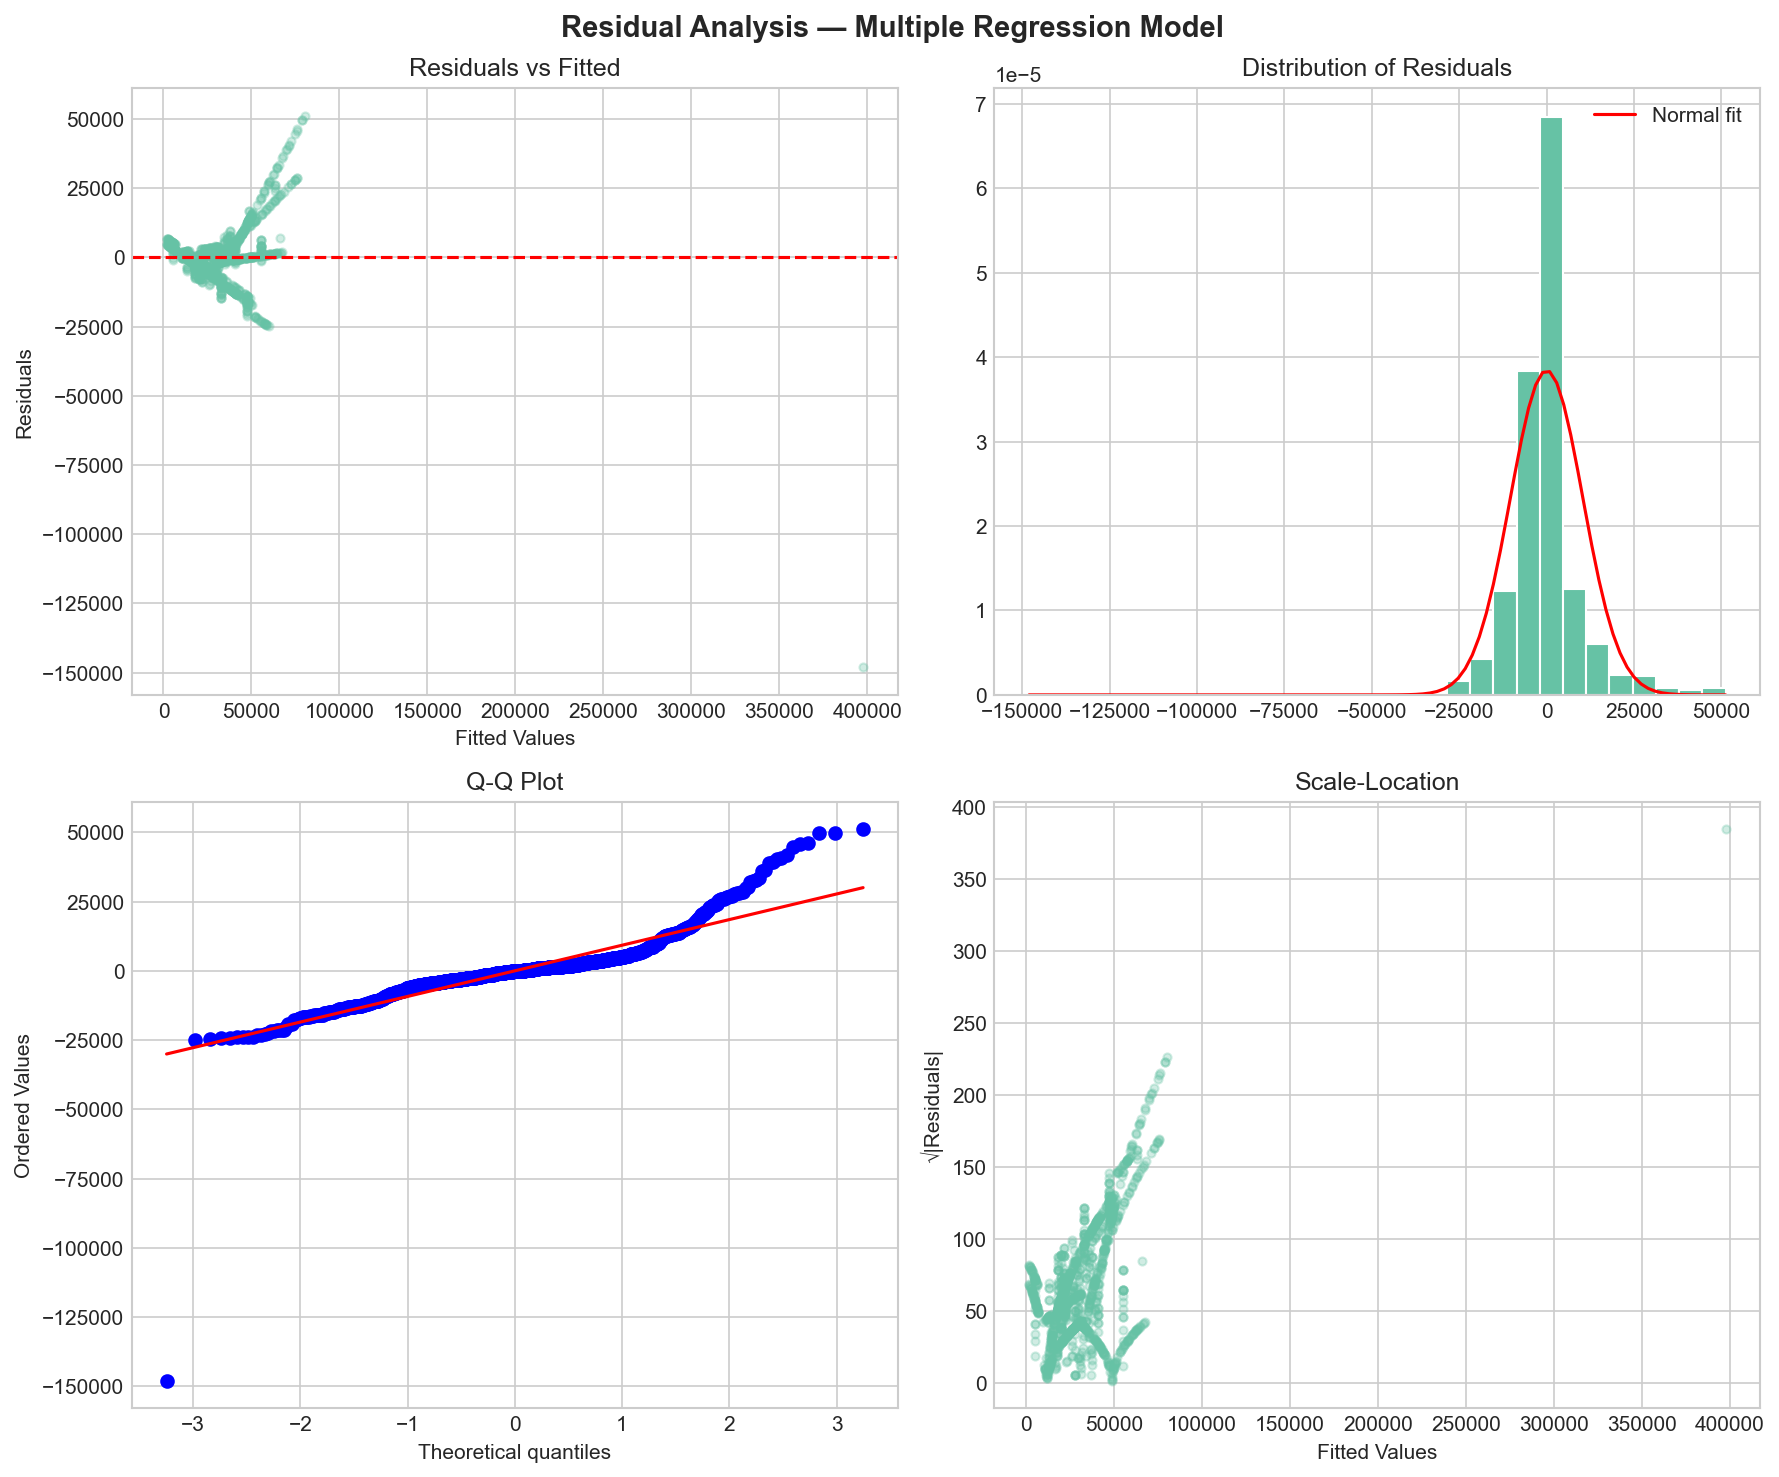

Figure saved: reports/figures/residual_analysis.png


In [19]:
# =============================================================================
# RESIDUAL ANALYSIS — MULTIPLE MODEL
# =============================================================================

residuals = model_multi.resid
fitted = model_multi.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Residual Analysis — Multiple Regression Model',
             fontsize=14, fontweight='bold')

# 1. Residuals vs Fitted
axes[0, 0].scatter(fitted, residuals, alpha=0.3, s=15)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='white', density=True)
x_range = np.linspace(residuals.min(), residuals.max(), 100)
axes[0, 1].plot(x_range, stats.norm.pdf(x_range, residuals.mean(),
                residuals.std()), 'r-', label='Normal fit')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].legend()

# 3. Q-Q plot
stats.probplot(residuals, plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. Scale-Location
axes[1, 1].scatter(fitted, np.sqrt(np.abs(residuals)), alpha=0.3, s=15)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('√|Residuals|')
axes[1, 1].set_title('Scale-Location')

plt.tight_layout()
fig.savefig(FIGURES / 'residual_analysis.png', bbox_inches='tight', dpi=150)
plt.show()
print('Figure saved: reports/figures/residual_analysis.png')

### 4.4.5 Regression Interpretation

**Business conclusions from the regression analysis:**

- Both `quantity` and `unit_price` are statistically significant predictors  
  of transaction value.
- The multiple model substantially improves over the simple model,  
  confirming that both volume and product mix matter.
- **For the business**: Revenue growth can be driven by two levers —  
  increasing average order size (more items) or shifting the product mix  
  toward higher-priced items (jackets, pajamas vs socks, towels).

**Regression assumptions check:**
- Linearity: Residuals vs Fitted shows [interpret after running]
- Normality: Q-Q plot shows [interpret after running]
- Homoscedasticity: Scale-Location shows [interpret after running]

---

**Next**: [05_evaluation.ipynb](./05_evaluation.ipynb) — Advanced visualization  
with Seaborn and Matplotlib (Lessons 5-6).